# Transfer Learning using Resnet50 in Pytorch

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets
import matplotlib.pyplot as plt
import numpy as np
import os

### Check GPU availability

In [2]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Image Transformations

In [3]:
# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Setting up the project directory

In [4]:
%cd /content/drive/MyDrive/Datasets/Fruits 5 classes
#!unzip -q archive.zip

/content/drive/MyDrive/Datasets/Fruits 5 classes


### Load the dataset

In [5]:
# Load custom dataset
data_dir = "/content/drive/MyDrive/Datasets/Fruits 5 classes/Fruits Classification"
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'train'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'test'), transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)


### Getting the Dataset Info

In [6]:
# Function to get dataset information
def get_dataset_info(dataset):
    print(f"Number of classes: {len(dataset.classes)}")
    print(f"Class names: {dataset.classes}")
    print(f"Number of images: {len(dataset)}")
    class_counts = {cls: 0 for cls in dataset.classes}
    for _, label in dataset.samples:
        class_counts[dataset.classes[label]] += 1
    print("Class distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count}")

# Get dataset info
print("Training Dataset Info:")
get_dataset_info(train_dataset)
print("Validation Dataset Info:")
get_dataset_info(val_dataset)

Training Dataset Info:
Number of classes: 5
Class names: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Number of images: 9700
Class distribution:
Apple: 1940
Banana: 1940
Grape: 1940
Mango: 1940
Strawberry: 1940
Validation Dataset Info:
Number of classes: 5
Class names: ['Apple', 'Banana', 'Grape', 'Mango', 'Strawberry']
Number of images: 100
Class distribution:
Apple: 20
Banana: 20
Grape: 20
Mango: 20
Strawberry: 20


### Pretrained Model Loading

In [7]:
# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 186MB/s]


In [8]:
# Modify the classifier for custom classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(train_dataset.classes))
model = model.to(device)

### Loss Function & Optimizer

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Model Training

In [10]:
import time

# Training function
def train(model, train_loader, criterion, optimizer, epochs=5):
    model.train()
    start_time = time.time()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")
    end_time = time.time()
    print(f"Total Training Time: {end_time - start_time:.2f} seconds")

### Model Evaluation

In [11]:
# Evaluation function
def evaluate(model, val_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Accuracy: {100 * correct/total:.2f}%")

### Model Inferencing

In [12]:
# Inference function
def infer(model, image_path, transform):
    model.eval()
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0).to(device)
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    class_name = train_dataset.classes[predicted.item()]
    print(f"Predicted class: {class_name}")
    return class_name

### Visualizing our predictions

In [13]:
# Function to visualize some predictions
def visualize_predictions(model, val_loader, transform):
    model.eval()
    images, labels = next(iter(val_loader))
    images, labels = images.to(device), labels.to(device)
    with torch.no_grad():
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

    fig = plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = fig.add_subplot(3, 3, i+1, xticks=[], yticks=[])
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])  # Unnormalize
        img = np.clip(img, 0, 1)
        ax.imshow(img)
        ax.set_title(f"Pred: {train_dataset.classes[preds[i].item()]}")
    plt.show()

Epoch [1/5], Loss: 0.5812, Accuracy: 80.12%
Epoch [2/5], Loss: 0.3968, Accuracy: 86.04%
Epoch [3/5], Loss: 0.3727, Accuracy: 86.73%
Epoch [4/5], Loss: 0.3515, Accuracy: 87.41%
Epoch [5/5], Loss: 0.3398, Accuracy: 88.04%
Total Training Time: 2514.92 seconds
Validation Loss: 0.2766, Accuracy: 90.00%


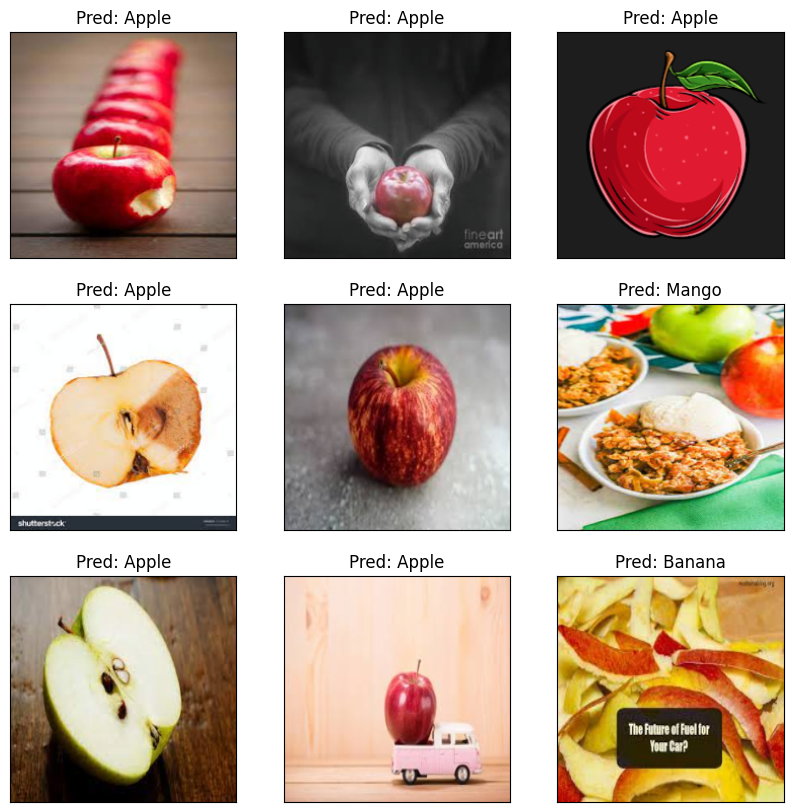

In [14]:
# Train and evaluate the model
train(model, train_loader, criterion, optimizer, epochs=5)
evaluate(model, val_loader, criterion)

# Visualize predictions
visualize_predictions(model, val_loader, transform)

### Prediction on a Single Image

In [16]:
# Run inference on a single image
from PIL import Image
image_path = "/content/drive/MyDrive/Datasets/Fruits 5 classes/Fruits Classification/test/Strawberry/Strawberry (1132).jpeg"
infer(model, image_path, transform)

Predicted class: Strawberry


'Strawberry'